In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))

from src import lmpc
from src.lmpc.utils import generateCoupledPendulumsLTI, plot_topology_locality

In [2]:
# system params
N = 4         # number of pendulums
Ns = 2        # states per subsystem
Na = 1        # acitons per subsystem
LOCALITY = 1
T = 10        # mpc horizon
Tsim = 50     # scenario sim time

# dynamics matrix of random mesh system
A, B = generateCoupledPendulumsLTI()
# cost matrices
Q = np.eye(N*Ns)
R = np.eye(N*Na)

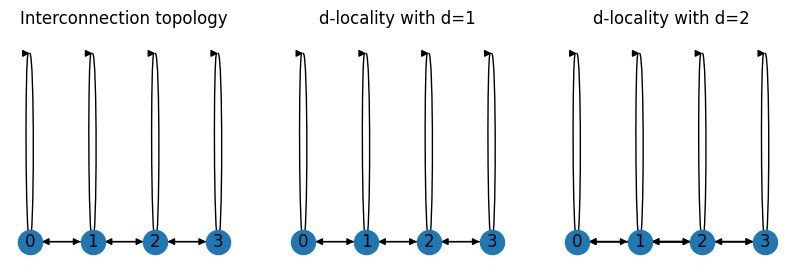

In [3]:
# init system
sys = lmpc.DistributedLTI(N, Ns, Na)
sys.loadAB(A, B)
sys << lmpc.dLocality(d=LOCALITY)
plot_topology_locality(sys, N, LOCALITY)

In [4]:
# init controller
controller = lmpc.LMPC(T)
controller << sys

# add objective
controller.addObjectiveFun(lmpc.objectives.QuadForm(Q, R))
# add terminal constraint (= 0 by default)
controller.addConstraint(lmpc.constraints.TerminalConstraint())

In [5]:
# run scenario
x0 = 0.5 * np.ones((sys.Nx, 1))
sys.setInitialState(x0)
cost_history = np.zeros((Tsim))
x_history = np.zeros((Tsim+1, 1, sys.Nx))
x_history[0] = x0.T

# run scenrario
for t in range(Tsim):
  u, cost = controller.solve(sys._x)
  x = sys.step(u)
  sys.updateState(x) 
  cost_history[t] = cost
  x_history[t+1, 0, :] = x.squeeze()

Initial cost = 254.43136321929475


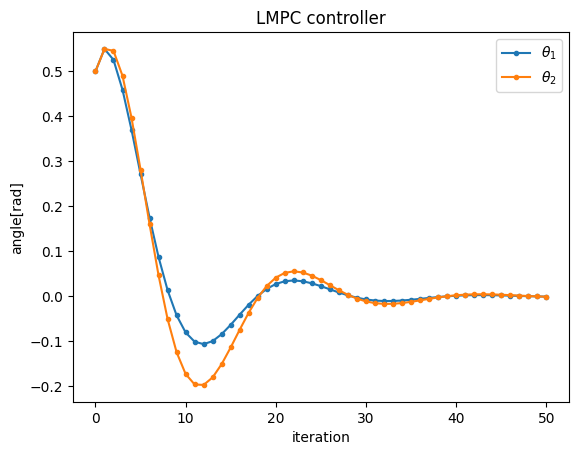

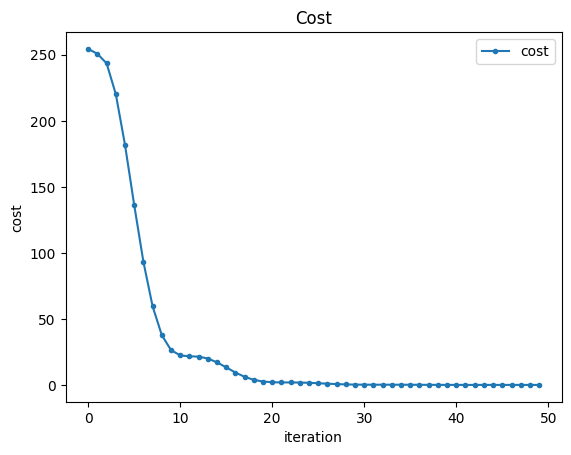

In [6]:
# Visualization
plt.plot(np.arange(0, Tsim+1), x_history[:, 0, 0], ".-", label="$\\theta_1$")
plt.plot(np.arange(0, Tsim+1), x_history[:, 0, 2], ".-", label="$\\theta_2$")
plt.xlabel("iteration")
plt.ylabel("angle[rad]")
plt.title("LMPC controller")
plt.legend(loc="best")


plt.figure()
plt.plot(np.arange(0, Tsim), cost_history, ".-", label="cost")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Cost")
plt.legend(loc="best")

print(f"Initial cost = {cost_history[0]}")